# PyTorch - Performance Tuning NLP BERT model Serving using Triton on SageMaker

This notebook demonstrates the use of Amazon SageMaker Inference recommender to perform custom load testing in order to performance fine tune the NLP BERT Model serving using NVIDIA Triton Serving on SageMaker.

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) is a fully managed service for data science and machine learning workflows. It helps data scientists and developers to prepare, build, train, and deploy high-quality ML models quickly by bringing together a broad set of capabilities purpose-built for ML.

Now, [NVIDIA Triton Inference Server](https://github.com/triton-inference-server/server/) can be used to serve models for inference in Amazon SageMaker. Thanks to the new NVIDIA Triton container image, you can easily serve ML models and benefit from the performance optimizations, dynamic batching, and multi-framework support provided by NVIDIA Triton. Triton helps maximize the utilization of GPU and CPU, further lowering the cost of inference.

SageMaker Inference Recommender is a new capability of SageMaker that reduces the time required to get machine learning (ML) models in production by automating performance benchmarking and load testing models across SageMaker ML instances. You can use Inference Recommender to deploy your model to a real-time inference endpoint that delivers the best performance at the lowest cost.

This notebook was tested with the `conda_python3` kernel on an Amazon SageMaker notebook instance of type `g4dn`.

## Introduction to NVIDIA Triton Server

[NVIDIA Triton Inference Server](https://github.com/triton-inference-server/server/) was developed specifically to enable scalable, cost-effective, and easy deployment of models in production. NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance.

Some key features of Triton are:
* **Support for Multiple frameworks**: Triton can be used to deploy models from all major frameworks. Triton supports TensorFlow GraphDef, TensorFlow SavedModel, ONNX, PyTorch TorchScript, TensorRT, RAPIDS FIL for tree based models, and OpenVINO model formats. 
* **Model pipelines**: Triton model ensemble represents a pipeline of one or more models or pre/post processing logic and the connection of input and output tensors between them. A single inference request to an ensemble will trigger the execution of the entire pipeline.
* **Concurrent model execution**: Multiple models (or multiple instances of the same model) can run simultaneously on the same GPU or on multiple GPUs for different model management needs.
* **Dynamic batching**: For models that support batching, Triton has multiple built-in scheduling and batching algorithms that combine individual inference requests together to improve inference throughput. These scheduling and batching decisions are transparent to the client requesting inference.
* **Diverse CPUs and GPUs**: The models can be executed on CPUs or GPUs for maximum flexibility and to support heterogeneous computing requirements.

**Note**: This initial release of NVIDIA Triton on SageMaker will only support a single model. Future releases will have multi-model support. A minimal `config.pbtxt` configuration file is **required** in the model artifacts. This release doesn't support inferring the model config automatically.

#### Install packages

Installs the dependencies required to package the model and run inferences using Triton server.

In [1]:
!pip install -qU pip awscli boto3 sagemaker transformers==4.9.1
!pip install nvidia-pyindex
!pip install tritonclient[http]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


#### Imports

In [2]:
#general imports
import boto3
import json
import os
import re
import copy
import time
from time import gmtime, strftime
import numpy as np
import datetime
import pprint
import pandas as pd

#sagemaker
import sagemaker
from sagemaker import get_execution_role

#triton
import tritonclient.http as httpclient

#transformers
from transformers import BertTokenizer

#custom cloudwatch
from cloudwatch import get_endpoint_metrics


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


#### Set Varaibles

We set SageMaker variables and other varibable below, also define the IAM role that will give Amazon SageMaker access to the model artifacts and the NVIDIA Triton ECR image.

In [3]:
sess = boto3.Session()
sm = sess.client("sagemaker")
sagemaker_session = sagemaker.Session(boto_session=sess)
role = get_execution_role()
#client = boto3.client("sagemaker-runtime")
region = boto3.Session().region_name
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/pt-triton-inference-recommender"

sm_client = boto3.client("sagemaker", region_name=region)
cw_client = boto3.client("cloudwatch", region)

account_id_map = {
    'us-east-1': '785573368785',
    'us-east-2': '007439368137',
    'us-west-1': '710691900526',
    'us-west-2': '301217895009',
    'eu-west-1': '802834080501',
    'eu-west-2': '205493899709',
    'eu-west-3': '254080097072',
    'eu-north-1': '601324751636',
    'eu-south-1': '966458181534',
    'eu-central-1': '746233611703',
    'ap-east-1': '110948597952',
    'ap-south-1': '763008648453',
    'ap-northeast-1': '941853720454',
    'ap-northeast-2': '151534178276',
    'ap-southeast-1': '324986816169',
    'ap-southeast-2': '355873309152',
    'cn-northwest-1': '474822919863',
    'cn-north-1': '472730292857',
    'sa-east-1': '756306329178',
    'ca-central-1': '464438896020',
    'me-south-1': '836785723513',
    'af-south-1': '774647643957'
}


if region not in account_id_map.keys():
    raise("UNSUPPORTED REGION")
    
print(f"SageMaker Role: {role}")
print(f"Region Name: {region}")

SageMaker Role: arn:aws:iam::917092859813:role/service-role/viridian-sagemaker-notebook-SageMakerExecutionRole-1KL5F03PT23NN
Region Name: us-east-1


In [4]:
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = "pt-triton-benchmark-model-" + ts
model_package_group_name = "pt-triton-benchmark-model-group-" + ts
advanced_job = "pt-triton-benchmark-advanced-job-" + ts

print(f"SageMaker Model Name: {sm_model_name}")
print(f"SageMaker Mode Package Name: {model_package_group_name}")
print(f"SageMaker Advanced Job Name: {advanced_job}")

SageMaker Model Name: pt-triton-benchmark-model-2022-04-07-16-11-37
SageMaker Mode Package Name: pt-triton-benchmark-model-group-2022-04-07-16-11-37
SageMaker Advanced Job Name: pt-triton-benchmark-advanced-job-2022-04-07-16-11-37


#### Amazon SageMaker Triton Inference Server Deep Learning Container Image

Let's retrieve Amazon SageMaker NVIDIA Triton Inference server container image based on the account ID you are running this notebook.

Set `triton_image_uri` based on the `account_id` and `region` information

In [5]:
base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
triton_image_uri = "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:21.08-py3".format(
    account_id=account_id_map[region], region=region, base=base
)

print(f"Triton Inference server DLC image: {triton_image_uri}")

Triton Inference server DLC image: 785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:21.08-py3


## NLP Use case

Deploying and scaling NLP models in a production set up can be quite challenging. NLP models are often very large in size, containing millions of model parameters. Optimal model configurations are required to satisfy stringent performance and scalability of production grade NLP applications

In this notebook, we will benchmark a NLP use case using SageMaker Triton inference server and recommend performance tuning optimizations for the below NLP profile. We will use a large pre-trained transformer based `bert-large-uncased` model which has about 336 million model parameters. The input sentence used for the binary classification model will be padded and truncated to a maximum input sequence length 512 tokens. The inference load test will simulate to achieve 500 TPS (30000 maximum invocations per minute) and model latency of < 0.5 seconds (500 milliseconds)

## NVIDIA Triton Setup with Amazon SageMaker

1. We will use this [script](./workspace/generate_models.sh) to generate the `bert-large-uncased` model to be used with NVIDIA Triton inference server.
2. The script for loading the pre-trained `bert_large_uncased` model and saving it can be found in this [location](./workspace/pt_exporter.py)
3. Pre-trained model is loaded in torchscript format and model artifacts are jit traced with a dummy input and store in model.pt format
4. After the model is serialized we package it into the format that Triton and SageMaker expect it to be.
5. We used the pre-configured `config.pbtxt` file provided with this repo [here](./triton-serve-pt/bert/config.pbtxt) to specify model [configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) which Triton uses to load the model. 
6. We tar the model directory and upload it to s3 to later create a [SageMaker Model](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html).


**Note**: Amazon SageMaker expects the model tarball file to have a top level directory with the same name as the model defined in the `config.pbtxt`. Below is the sample model directory structure

```
bert
├── 1
│   └── model.pt
└── config.pbtxt
```

NOTE: The below script uses docker and thus will not work on Amazon SageMaker Studio notebook. Please use Amazon SageMaker Notebook instance to execute this notebook

In [6]:
!docker run --gpus=all --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/pytorch:21.08-py3 \
            /bin/bash generate_models.sh


== PyTorch ==

NVIDIA Release 21.08 (build 26011915)
PyTorch Version 1.10.0a0+3fd9dcf

Container image Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.

Copyright (c) 2014-2021 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

NVIDIA Deep Learning Profiler (dlprof) Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.

Various fil

The script saves the model in this [directory](./workspace/)

### Model Configuration

- Each model in a model repository must include a model configuration that provides required and optional information about the model. Typically, this configuration is provided in a `config.pbtxt` file specified as `ModelConfig protobuf`. 
- The model configuration name property is optional. If the name of the model is not specified in the configuration it is assumed to be the same as the model repository directory containing the model. If name is specified it must match the name of the model repository directory containing the model
- The `max_batch_size` property indicates the maximum batch size that the model supports for the types of batching that can be exploited by Triton. If the model's batch dimension is the first dimension, and all inputs and outputs to the model have this batch dimension, then Triton can use its dynamic batcher or sequence batcher to automatically use batching with the model. In this case `max_batch_size` should be set to a value greater-or-equal-to 1 that indicates the maximum batch size that Triton should use with the model
- Each model input and output must specify a name, datatype, and shape. The name specified for an input or output tensor must match the name expected by the model.

The below is the baseline configuration for PyTorch model

In [7]:
!mkdir -p triton-serve-pt/bert/

In [8]:
%%writefile triton-serve-pt/bert/config.pbtxt
platform: "pytorch_libtorch"
max_batch_size: 32
input [
  {
    name: "INPUT__0"
    data_type: TYPE_INT32
    dims: [512]
  },
  {
    name: "INPUT__1"
    data_type: TYPE_INT32
    dims: [512]
  }
]
output [
  {
    name: "OUTPUT__0"
    data_type: TYPE_FP32
    dims: [512, 768]
  },
  {
    name: "1634__1"
    data_type: TYPE_FP32
    dims: [768]
  }
]

Overwriting triton-serve-pt/bert/config.pbtxt


You can find other model configurations thats used in the benchmarching exercise in this [directory](./workspaces).

1. config-dg.pbtxt (Dynamic batching enabled)
2. config-ig.pbtxt (Multiple instance group)
3. config-db-ig.pbtxt (Dynamic batching, Multiple instance group enabled)

To execute benchmarking load using Amazon SageMaker Inference recommender copy above files with `config.pbtxt` and reupload the model tar files.

We will copy the model.pt file and create model tar file to be uploaded to S3. The model archieve tar file will be used by Triton Inference server

In [9]:
!mkdir -p triton-serve-pt/bert/1/
!cp workspace/model.pt triton-serve-pt/bert/1/
!tar -C triton-serve-pt/ -czf model.tar.gz bert
model_uri = sagemaker_session.upload_data(path="model.tar.gz", key_prefix="triton-serve-pt")

### Create Amazon SageMaker Real Time Endpoint

We start off by creating a [sagemaker model](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateModel.html) from the model files we uploaded to s3 in the previous step.

In this step we also provide an additional Environment Variable i.e. `SAGEMAKER_TRITON_DEFAULT_MODEL_NAME` which specifies the name of the model to be loaded by Triton. **The value of this key should match the folder name in the model package uploaded to s3**. This variable is optional in case of a single model. In case of ensemble models, this key **has to be** specified for Triton to startup in SageMaker.

Additionally, customers can set `SAGEMAKER_TRITON_BUFFER_MANAGER_THREAD_COUNT` and `SAGEMAKER_TRITON_THREAD_COUNT` for optimizing the thread counts.

*Note*: The current release of Triton (21.08-py3) on SageMaker doesn't support running instances of different models on the same server, except in case of [ensembles](https://github.com/triton-inference-server/server/blob/main/docs/architecture.md#ensemble-models). Only multiple model instances of the same model are supported, which can be specified under the [instance-groups](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md#instance-groups) section of the config.pbtxt file.

###  Create payload 

Create payload in JSON format and upload it on S3. This will be used by Inference Recommender to run the custom load test. 

In [10]:
def tokenize_text(text):
    enc = BertTokenizer.from_pretrained("bert-large-uncased")
    encoded_text = enc(text, padding="max_length", max_length=512,truncation=True)
    return encoded_text["input_ids"], encoded_text["attention_mask"]

If you want to change the payload (Token Length), below are the changes -
1. Change the JSON with shape reflecting the right token length below
2. Change the tokenize_text method to reflect the token length
3. Change the config.pbtxt the triton* folder to reflect the input id and attention mask length.

In [11]:
text_triton = """
                Create payload JSON and upload it on S3. 
                This will be used by Inference Recommender to run the load test.
              """

input_ids, attention_mask = tokenize_text(text_triton)

payload = {
    "inputs": [
        {"name": "INPUT__0", "shape": [1, 512], "datatype": "INT32", "data": input_ids},
        {"name": "INPUT__1", "shape": [1, 512], "datatype": "INT32", "data": attention_mask},
    ]
}

print(f"Sample payload to be used with Inference Recommender")
print(payload)

payload_location = "./sample-payload/"

if not os.path.exists(payload_location):
    os.makedirs(payload_location)
    print(f"Directory Created {payload_location}")
else:
    print(f"Directory already exists {payload_location}")

payload_archive_name = "payload.tar.gz"

f = open(payload_location+"request.json", "w")
json.dump(payload, f)
f.close()

!cd ./sample-payload/ && tar czvf ../payload.tar.gz *


Sample payload to be used with Inference Recommender
{'inputs': [{'name': 'INPUT__0', 'shape': [1, 512], 'datatype': 'INT32', 'data': [101, 3443, 18093, 1046, 3385, 1998, 2039, 11066, 2009, 2006, 1055, 2509, 1012, 2023, 2097, 2022, 2109, 2011, 28937, 16755, 2121, 2000, 2448, 1996, 7170, 3231, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
%%time

sample_payload_url = sagemaker.Session().upload_data(
    payload_archive_name, bucket=bucket, key_prefix=prefix + "/inference"
)

model_archive_name = "model.tar.gz"
model_url = sagemaker.Session().upload_data(
    model_archive_name, bucket=bucket, key_prefix=prefix + "/model"
)

print(f"Sample Payload location in S3:  {sample_payload_url}")
print(f"Model archieve location: {model_url}")

Sample Payload location in S3:  s3://sagemaker-us-east-1-917092859813/sagemaker/triton-inference-recommender/inference/payload.tar.gz
Model archieve location: s3://sagemaker-us-east-1-917092859813/sagemaker/triton-inference-recommender/model/model.tar.gz
CPU times: user 6.85 s, sys: 6.42 s, total: 13.3 s
Wall time: 5.2 s


### Amazon SageMaker Inference Recommender set up

Set the Domain, Task, Framework, version and Model for Inference Recommender Job. 

In [13]:
ml_domain = "NATURAL_LANGUAGE_PROCESSING"
ml_task = "FILL_MASK"
ml_framework = "PYTORCH"
framework_version = "1.6.0"
model = "bert-base-uncased"

Create the Triton Container Dictionary object and Model Package group for Inference recommender Job

In [14]:
container = {
    "Image": triton_image_uri,
    "ModelDataUrl": model_url,
    "NearestModelName": model,
    "Framework": ml_framework,
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "bert"},
}

In [15]:
model_pacakge_group_response = sm_client.create_model_package_group(
    ModelPackageGroupName=str(model_package_group_name),
    ModelPackageGroupDescription="BERT large uncased Model group for Triton Serving",
)
print(f"Model Registry package group: {model_pacakge_group_response}")

Model Registry package group: {'ModelPackageGroupArn': 'arn:aws:sagemaker:us-east-1:917092859813:model-package-group/pt-triton-benchmark-model-group-2022-04-07-16-11-37', 'ResponseMetadata': {'RequestId': '7cf8e2d4-250a-4cf5-ab30-8949bfc8d03b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7cf8e2d4-250a-4cf5-ab30-8949bfc8d03b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '139', 'date': 'Thu, 07 Apr 2022 16:13:54 GMT'}, 'RetryAttempts': 0}}


Amazon SageMaker model registry model package with domian, task and Inference container specification information. Specify the list of supported inference instance types in `SupportedRealtimeInferenceInstanceTypes` parameter. Also, define the `ContentType` and MIME type information

In [16]:
model_package_version_response = sm_client.create_model_package(
    ModelPackageGroupName=str(model_package_group_name),
    ModelPackageDescription="BERT large uncased Model group for Triton Serving",
    Domain=ml_domain,
    Task=ml_task,
    SamplePayloadUrl=sample_payload_url,
    InferenceSpecification={
        "Containers": [
            container
            
        ],
        "SupportedRealtimeInferenceInstanceTypes": [
            "ml.g4dn.4xlarge",
            "ml.g4dn.8xlarge",
            "ml.g4dn.16xlarge",
            "ml.g4dn.12xlarge",
            "ml.g4dn.xlarge",
            "ml.g4dn.2xlarge"
        ],
        "SupportedContentTypes": ["application/octet-stream"],
        "SupportedResponseMIMETypes": ["application/json"],
    },
)

### Amazon SageMaker Inference Recommender Custom Load Test

Create Custom Inference Recommender Job for Triton Container serving BERT Model with 512 Token length

Use the `create_inference_recommendations_job` to create an Inference Recommender load test and specify below paramters
- Specify Advanced for the JobType field and provide:
- A job name for your load test (JobName). 
- The Amazon Resource Name (ARN) of an IAM role that enables Inference Recommender to perform tasks on your behalf.
- A traffic pattern of the load test (TrafficPattern)
    - Initial number of users = 2
    - Spawn Rate = 3 (creates 3 new users every 3 minutes for a duration of 15 minutes)
- An endpoint configuration dictionary (InputConfig) where you specify an AWS instance type against which to run benchmarks
- StoppingConditions (Inference recommender would adjust the initial number of instances to satisfy below stopping conditions)
    - MaxInvocations is set to 30000 
    - ModelLatencyThresholds p95 threshold for 500 ms

In [17]:
advanced_response = sm_client.create_inference_recommendations_job(
    JobName=advanced_job,
    JobDescription="nlp triton Inference Advanced Recommender Job",
    JobType="Advanced",
    RoleArn=role,
    InputConfig={
        "ModelPackageVersionArn": model_package_version_response["ModelPackageArn"],
        "JobDurationInSeconds": 7200,
        "EndpointConfigurations": [{'InstanceType': 'ml.p3.8xlarge'},
                                {'InstanceType': 'ml.p3.2xlarge'},
                                {'InstanceType': 'ml.p3.16xlarge'},
                                {'InstanceType': 'ml.g4dn.xlarge'},
                                {'InstanceType': 'ml.g4dn.8xlarge'},
                                {'InstanceType': 'ml.g4dn.4xlarge'},
                                {'InstanceType': 'ml.g4dn.2xlarge'},
                                {'InstanceType': 'ml.g4dn.16xlarge'},
                                {'InstanceType': 'ml.g4dn.12xlarge'}],
        "TrafficPattern": {
            "TrafficType": "PHASES",
            "Phases": [{"InitialNumberOfUsers": 2, "SpawnRate": 3, "DurationInSeconds": 900}, # simulating 50 users, 2 initial and 3 new users every minute for 16 minutes 
                       ], # second phase, we will strt with 50 users, steady traffic for 5 minutes
        },
        "ResourceLimit": {
            "MaxNumberOfTests": 10,
            "MaxParallelOfTests": 5
        },
    },
    StoppingConditions={
        "MaxInvocations": 30000,
        "ModelLatencyThresholds": [{"Percentile": "P95", "ValueInMilliseconds": 500}],
    },
)

print(advanced_response)

{'JobArn': 'arn:aws:sagemaker:us-east-1:917092859813:inference-recommendations-job/pt-triton-benchmark-advanced-job-2022-04-07-16-11-37', 'ResponseMetadata': {'RequestId': 'da9ea59d-2703-4739-bdcf-8f680e320716', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'da9ea59d-2703-4739-bdcf-8f680e320716', 'content-type': 'application/x-amz-json-1.1', 'content-length': '136', 'date': 'Thu, 07 Apr 2022 16:13:55 GMT'}, 'RetryAttempts': 0}}


Let's get the inference recommender job details using `describe_inference_recommendations_job` boto3 api

In [21]:
%%time

ended = False
while not ended:
    inference_recommender_job = sm_client.describe_inference_recommendations_job(
        JobName=str(advanced_job)
    )
    if inference_recommender_job["Status"] in ["COMPLETED", "STOPPED", "FAILED"]:
        print(f"Inference recommender job status: {inference_recommender_job['Status']} ")
        ended = True
    else:
        print("Inference recommender job in progress")
        time.sleep(300)

if inference_recommender_job["Status"] == "FAILED":
    print("Inference recommender job failed ")
    print("Failed Reason: {}".inference_recommender_job["FailedReason"])
else:
    print("Inference recommender job completed")

Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job completed
CPU times: user 132 ms, sys: 26.7 ms, total: 159 ms
Wall time: 40min 7s


### Visualize Cloudwatch Metrics

Use `get_endpoint_metrics` helper functions, visualize the cloudwatch metrics. This will provide detailed overview of resource usage during the load test. Metrics such as GPU Memory utilization, Invocations and Model Latency metrics will allow to tweak NVIDIA Triton model configuration to improve application performance.

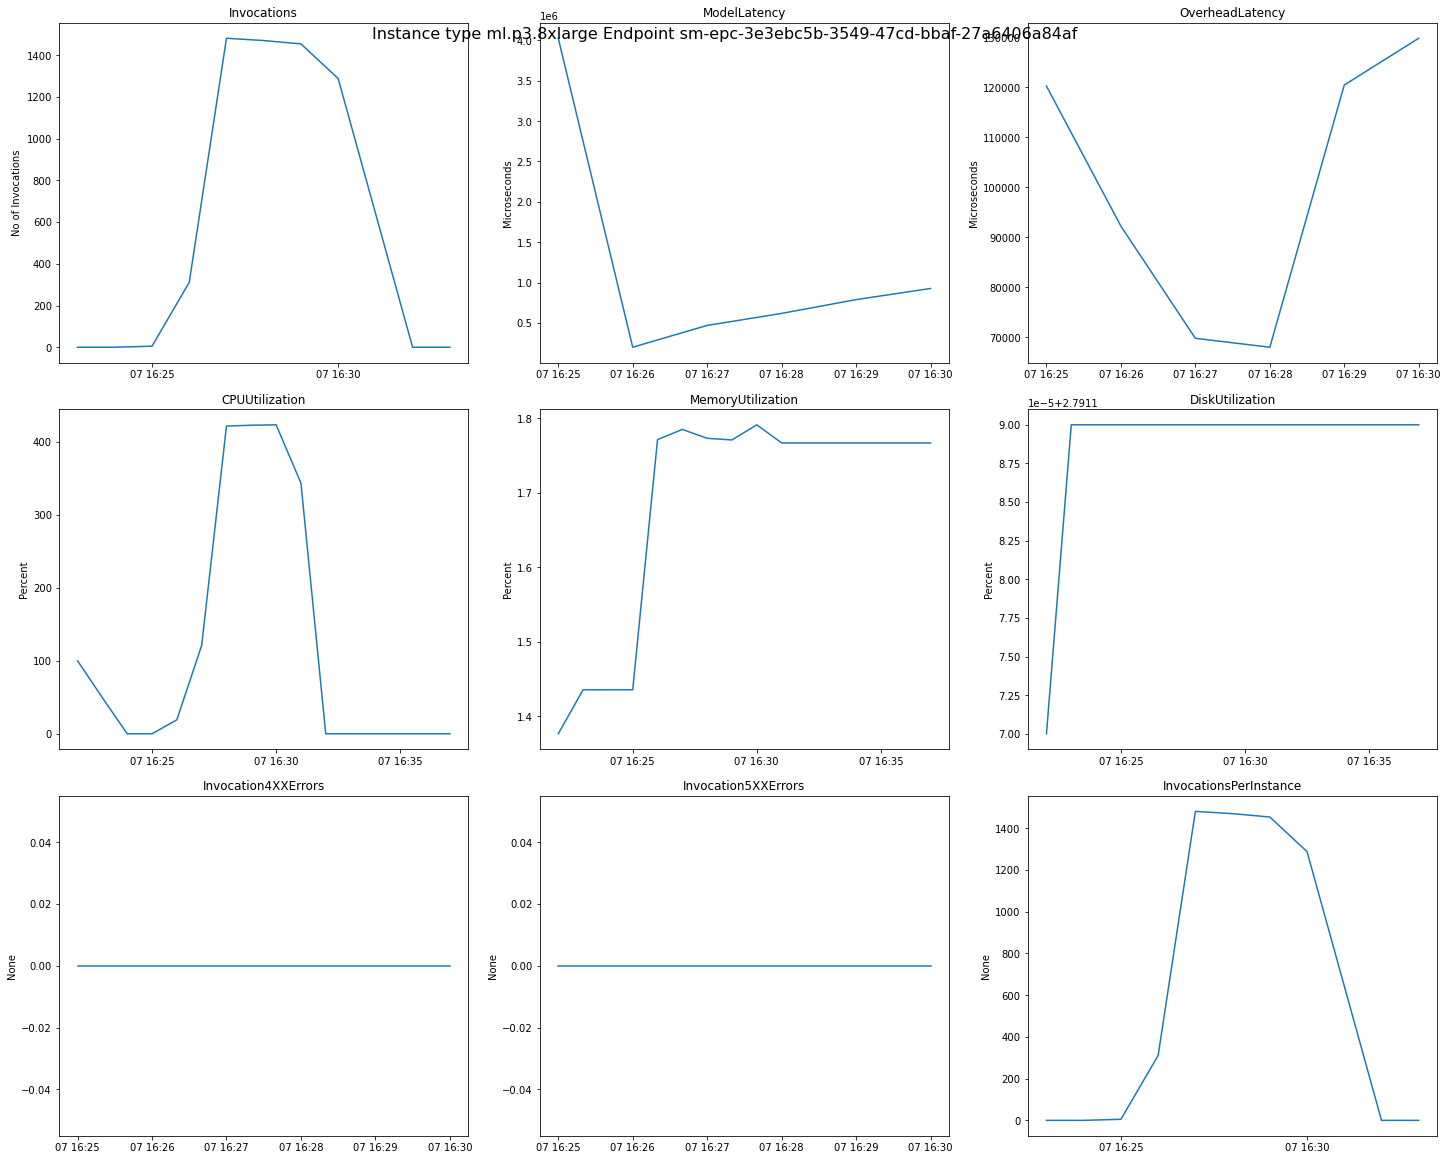

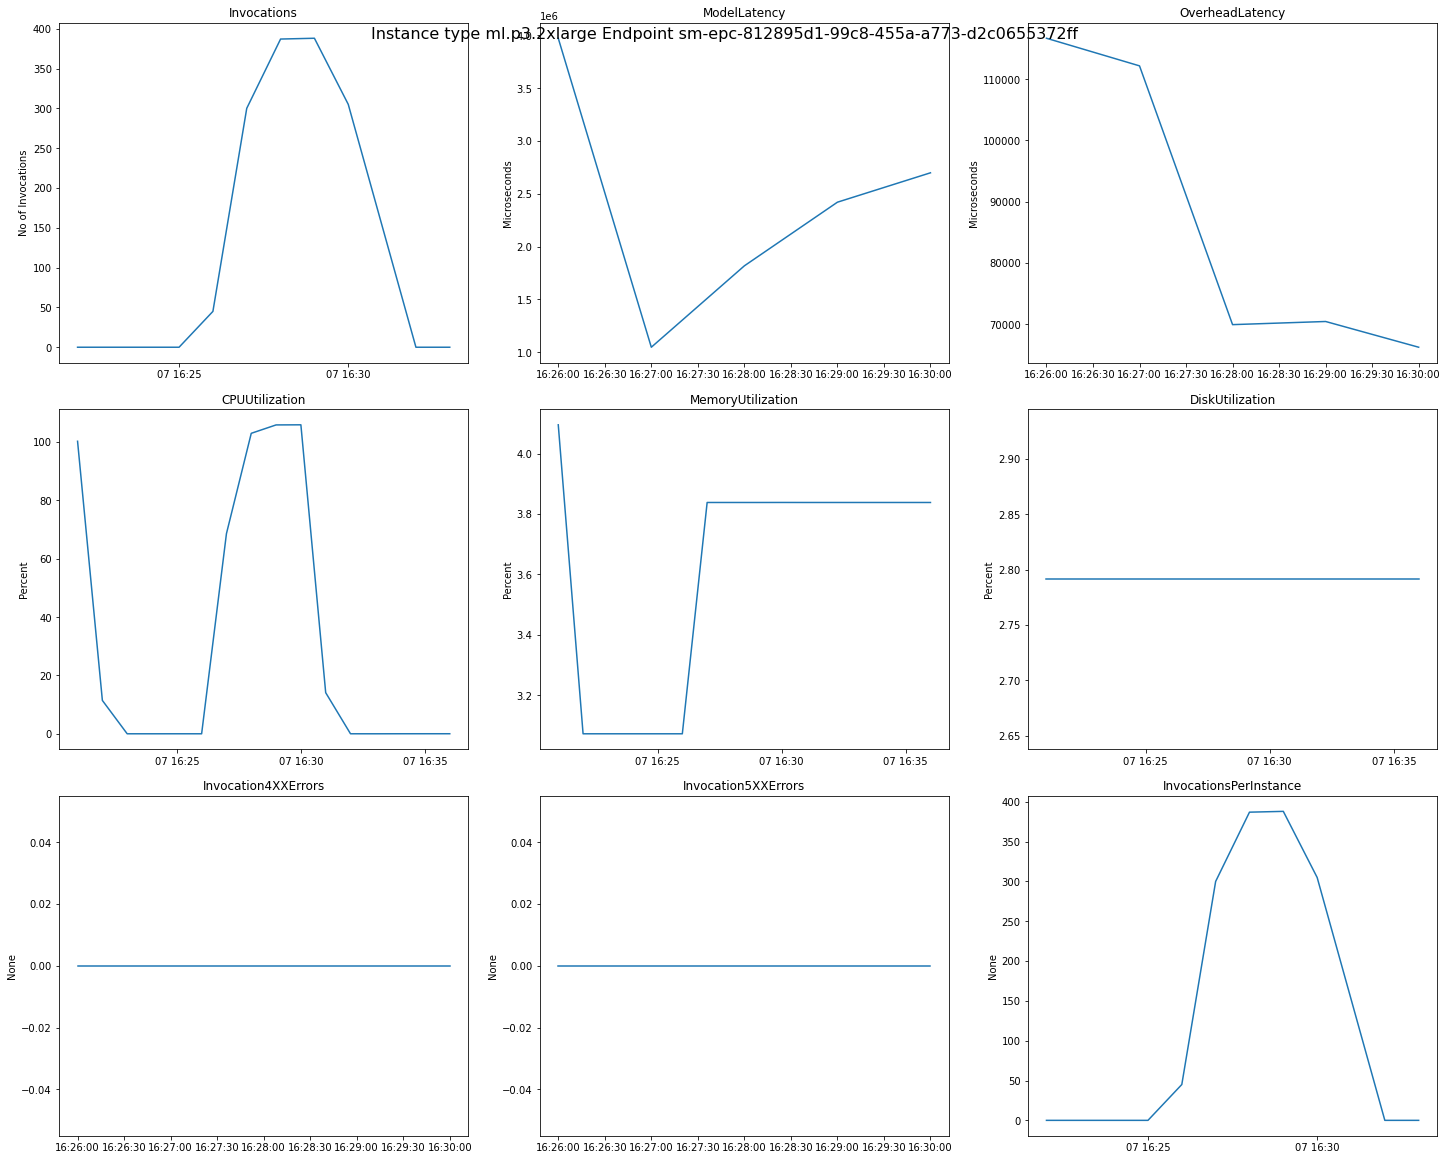

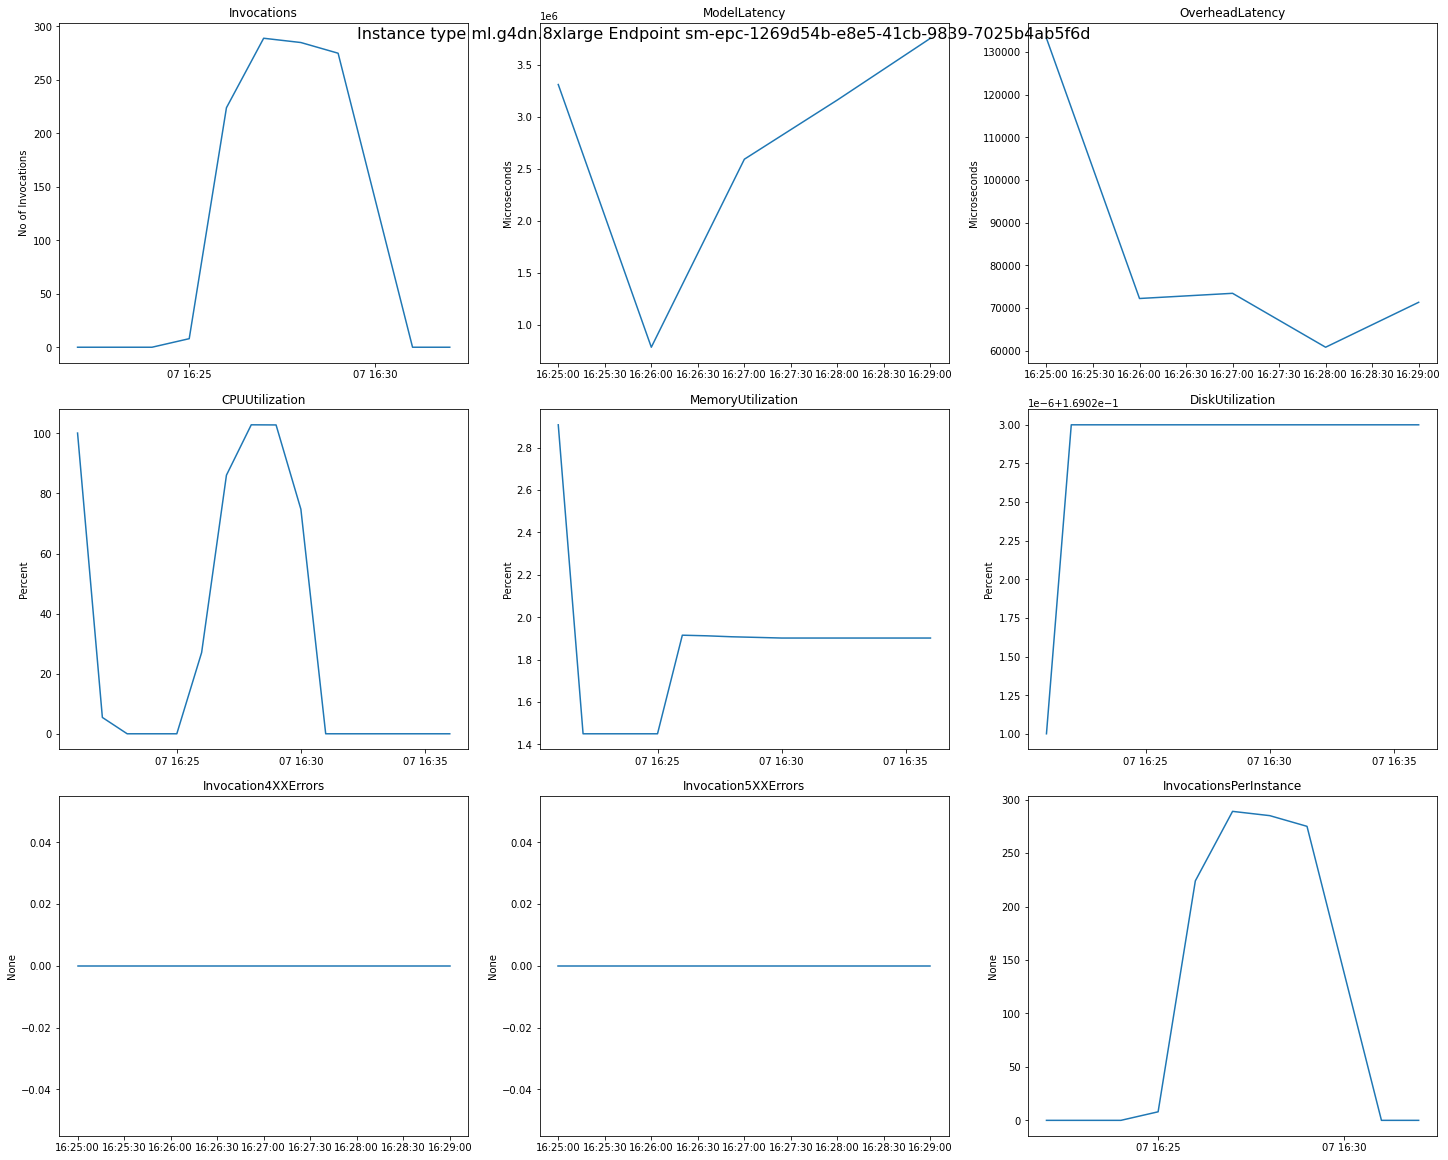

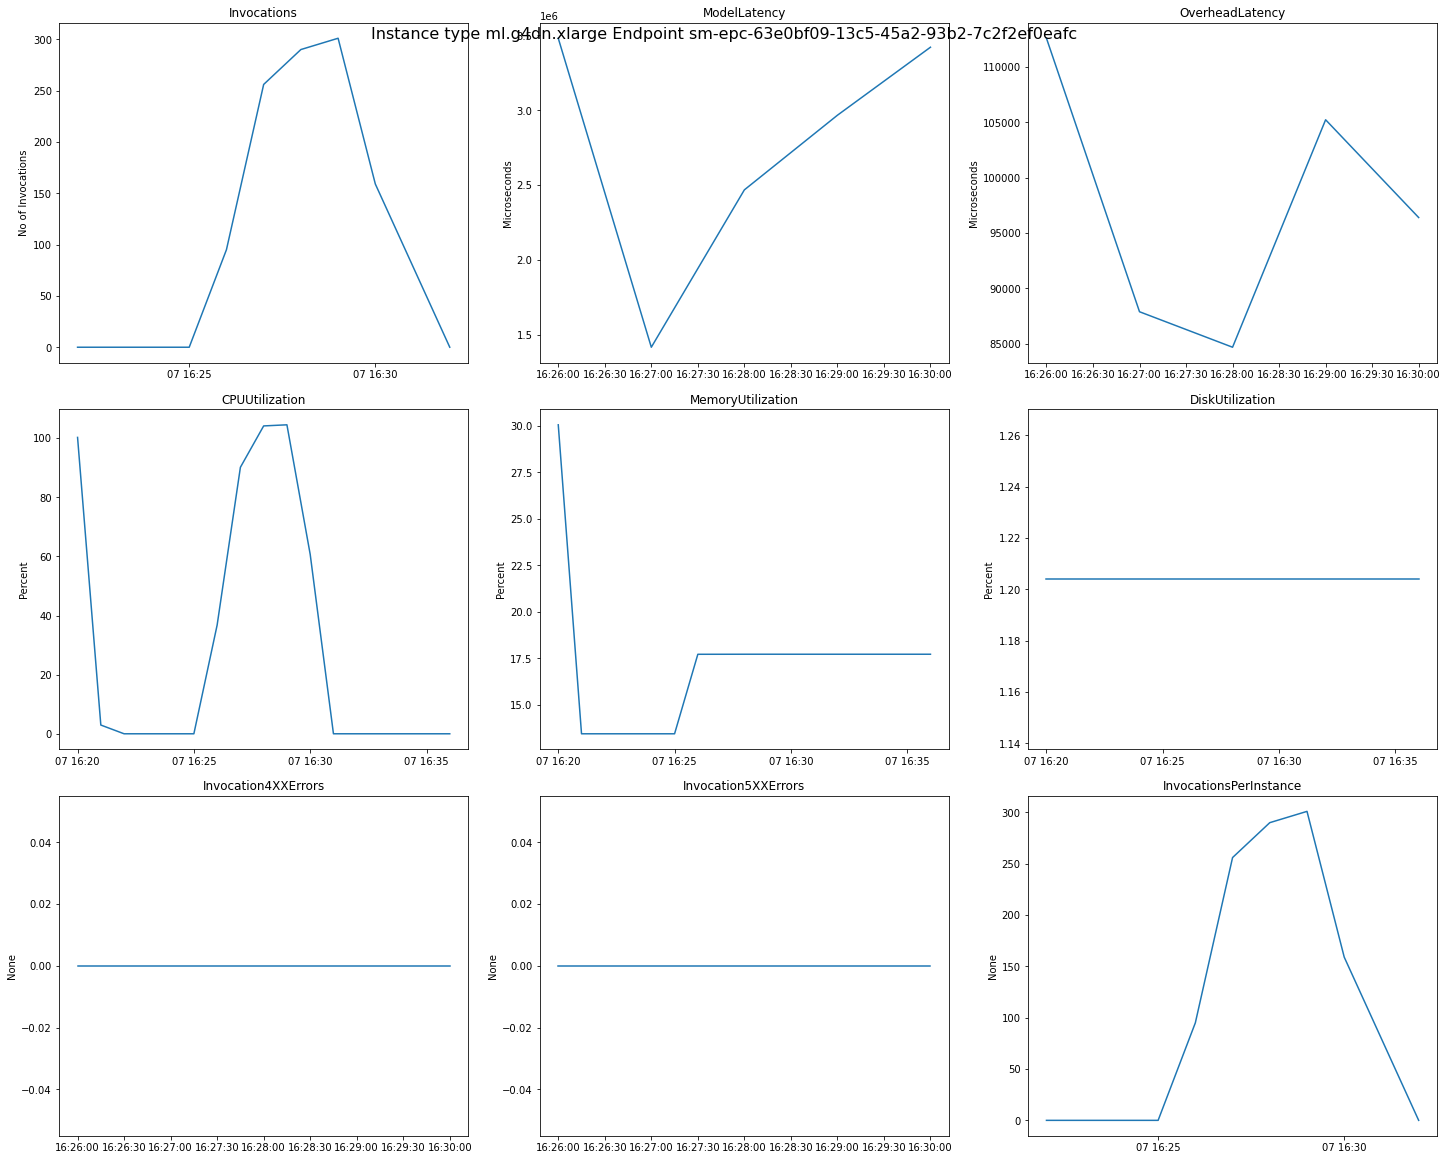

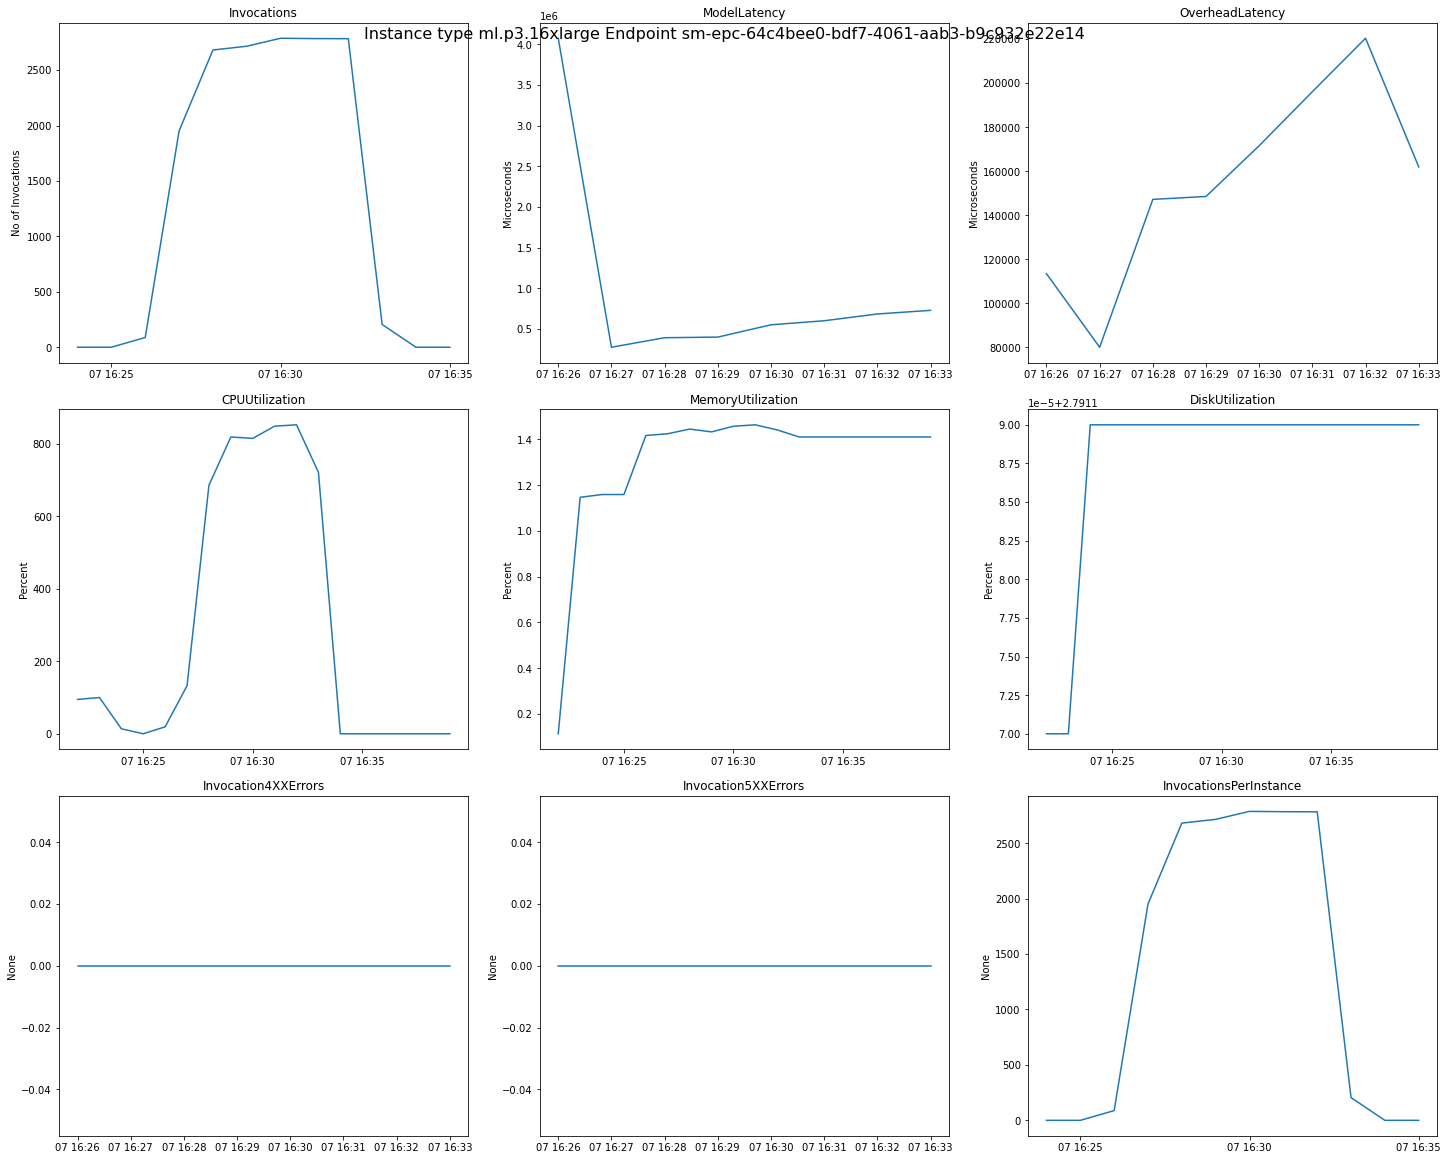

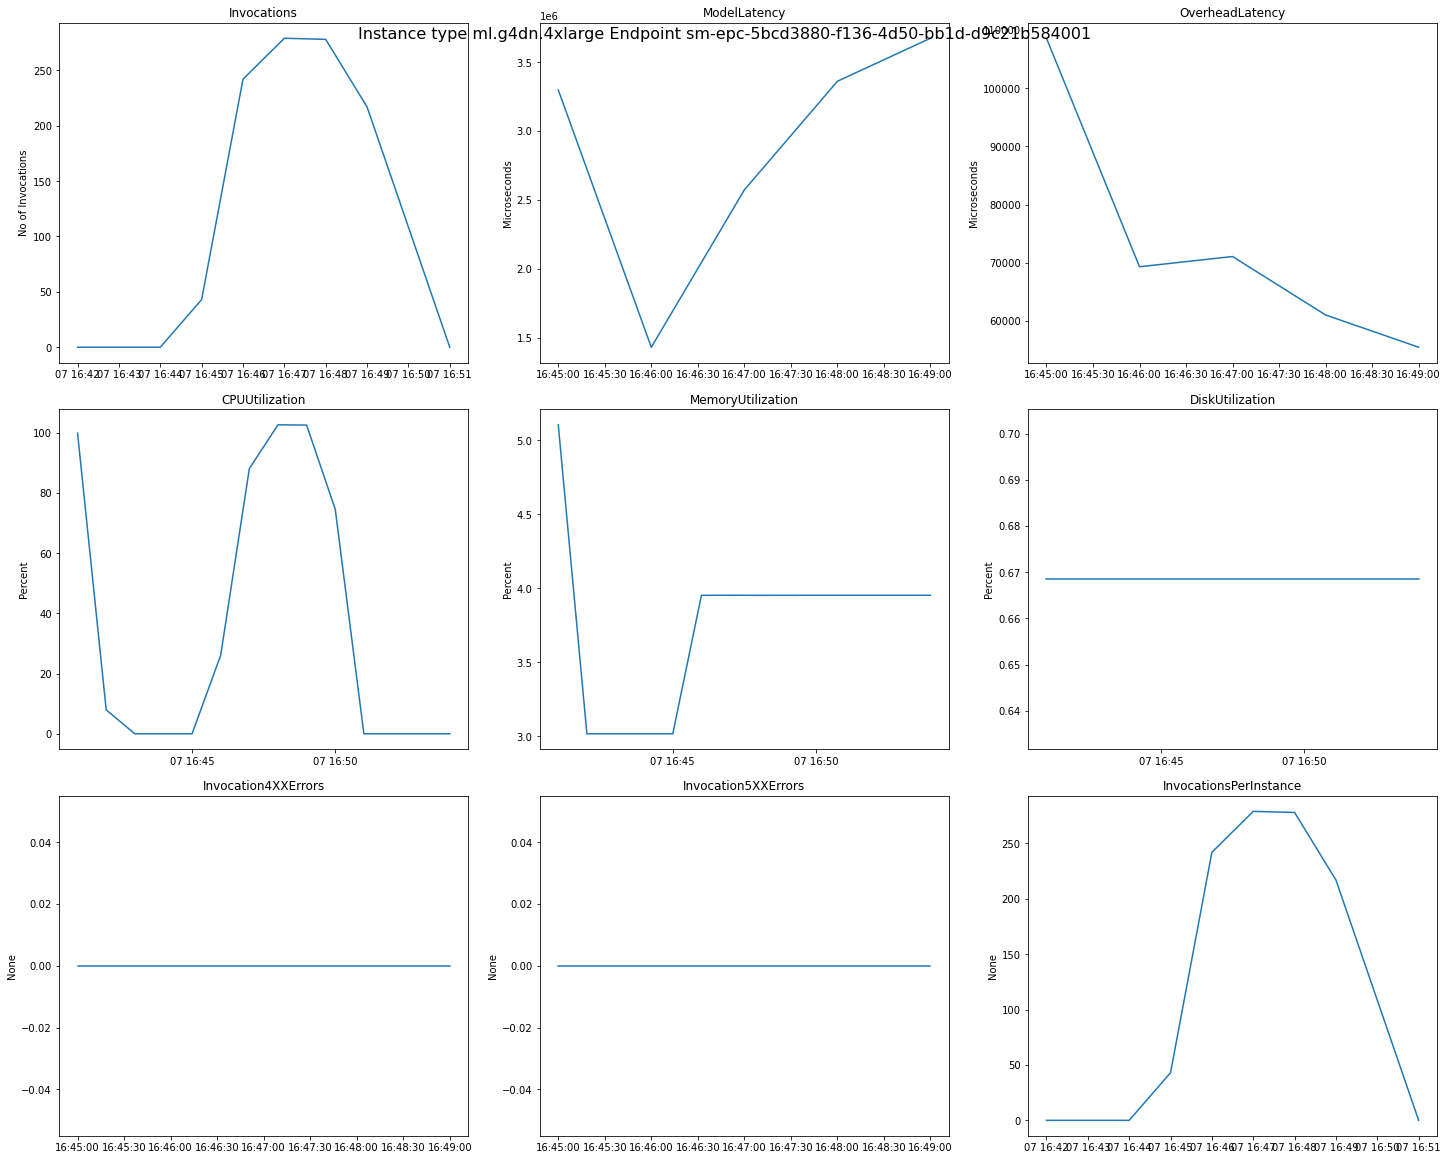

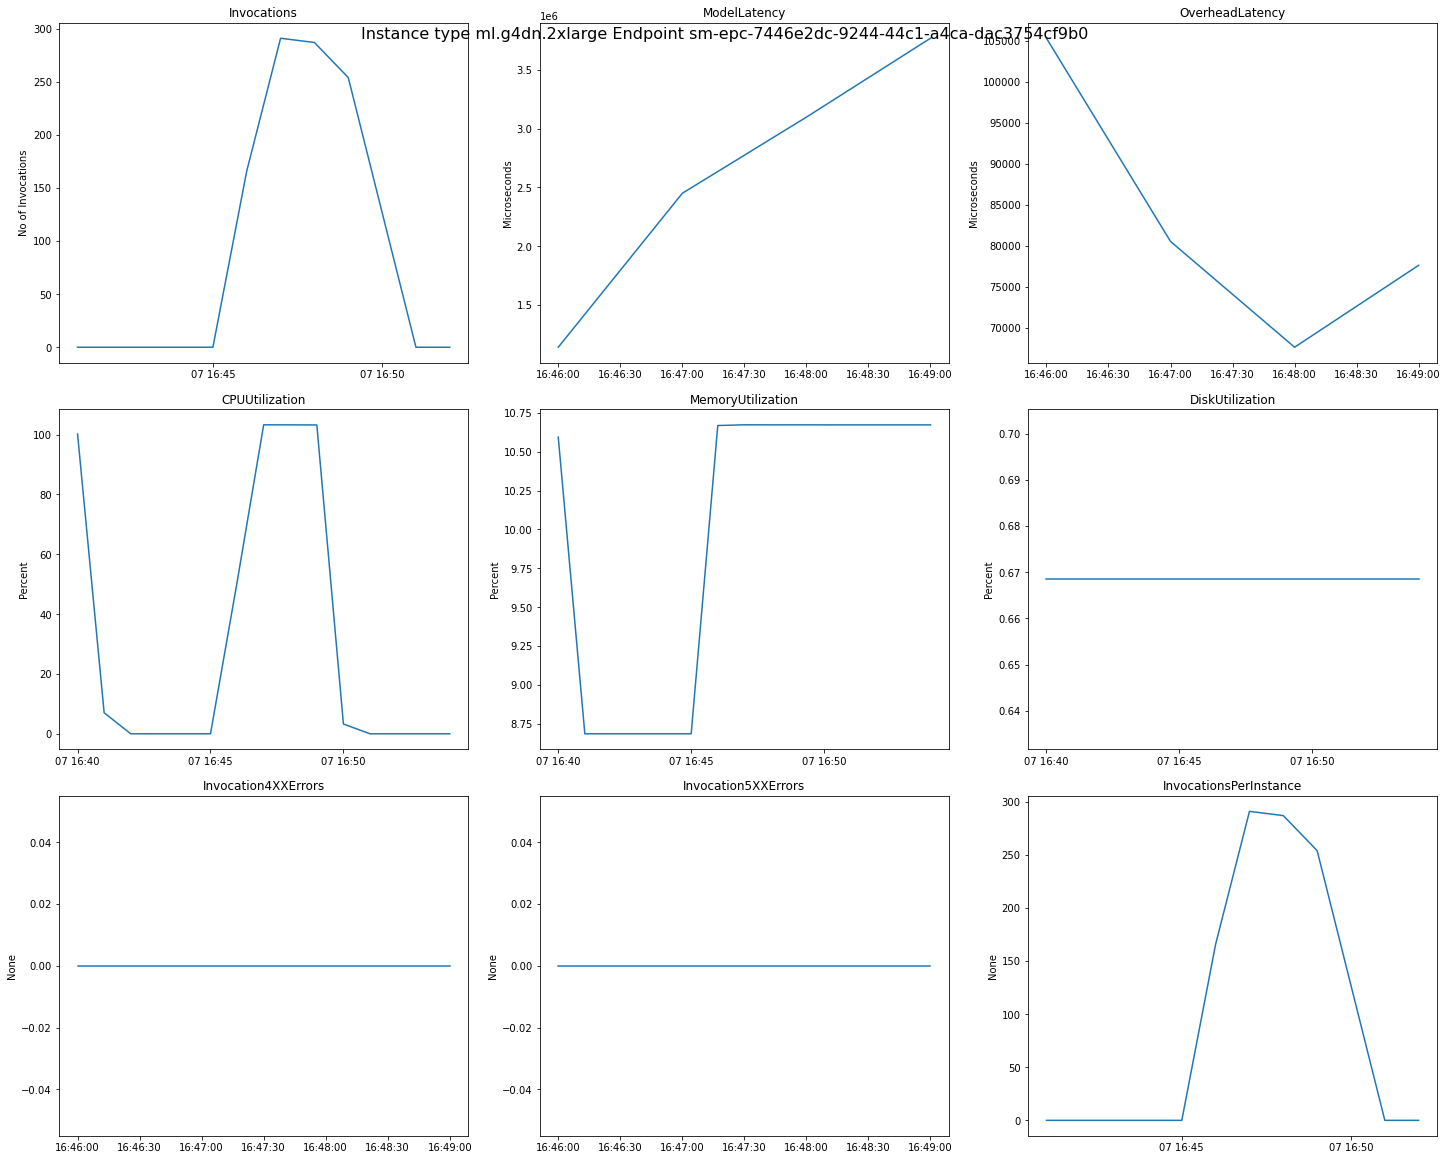

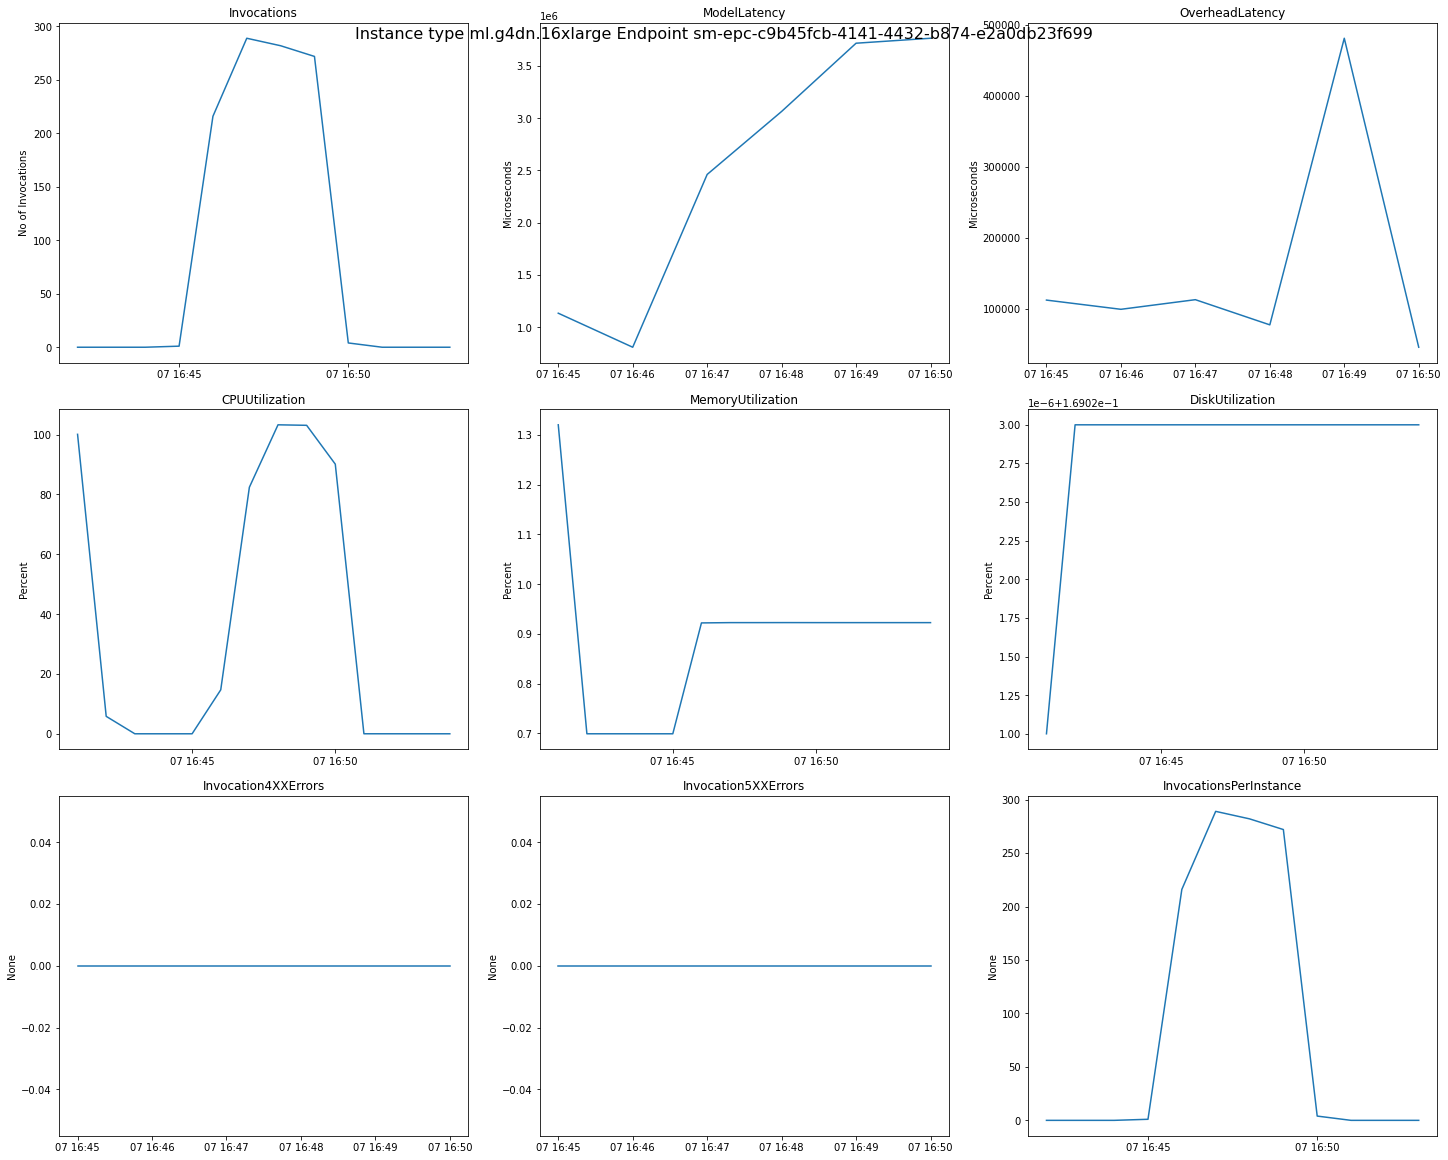

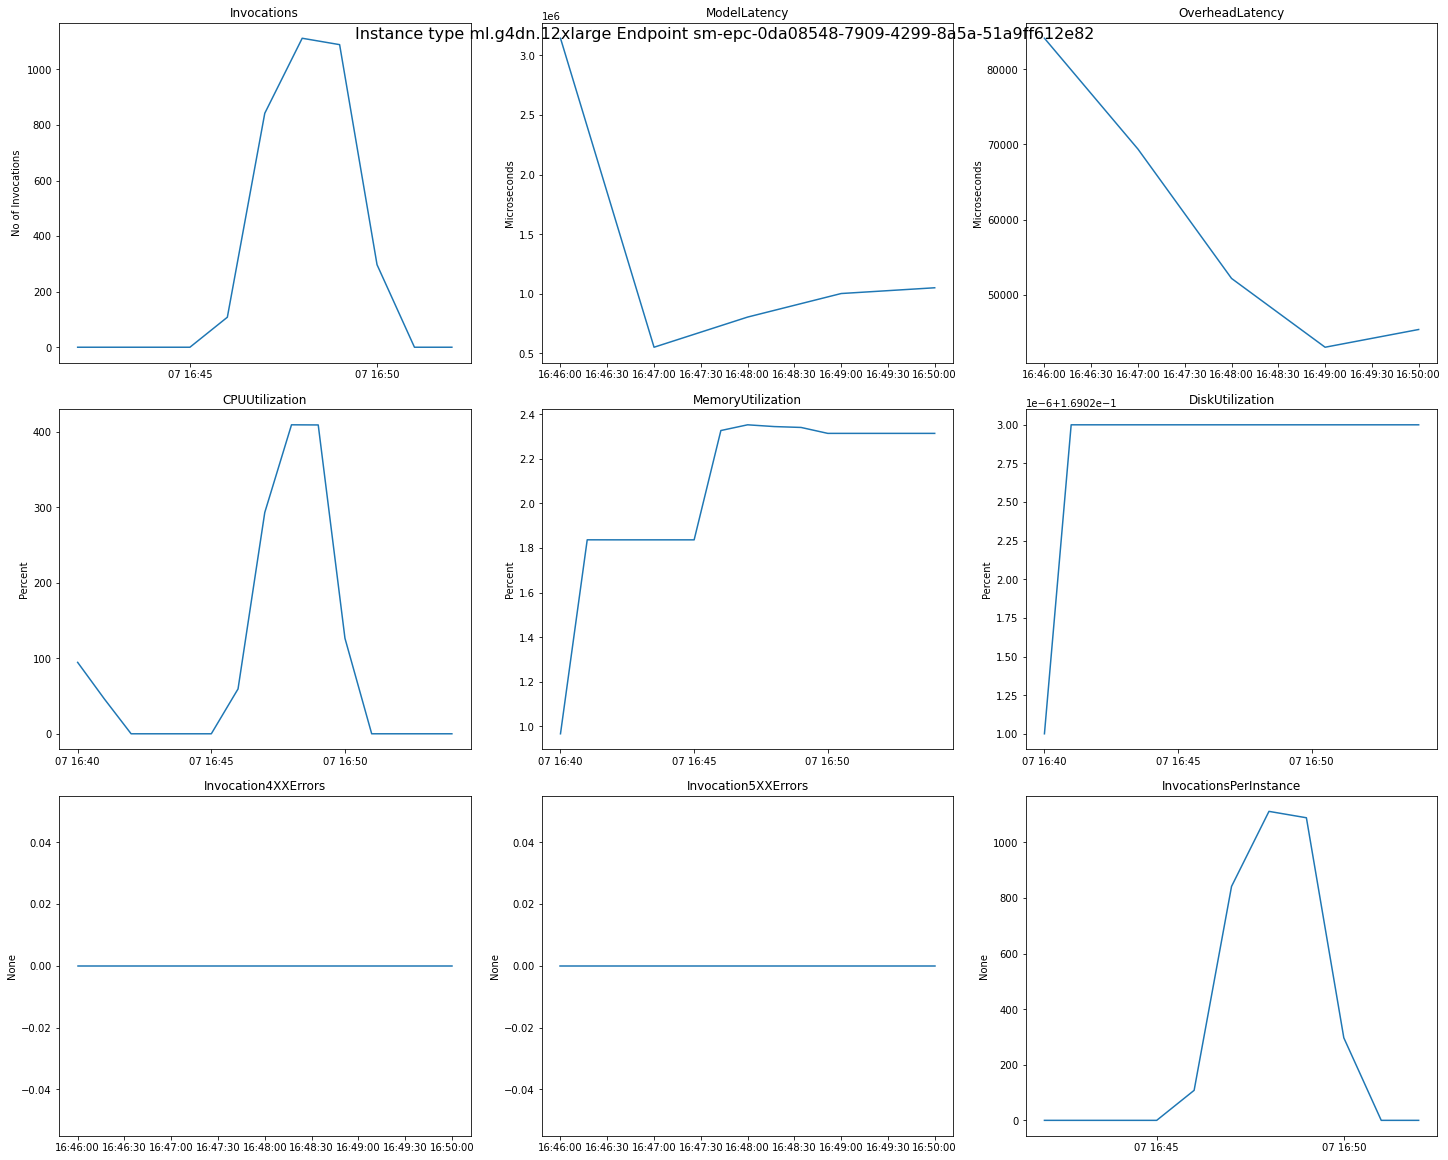

In [22]:
job_name = advanced_response['JobArn'].split('/')[-1]

df_cw = get_endpoint_metrics(sm_client, cw_client, region, job_name, include_plots=True)

In [23]:
data = [
    {**x["EndpointConfiguration"], **x["ModelConfiguration"], **x["Metrics"]}
    for x in inference_recommender_job["InferenceRecommendations"]
]
df = pd.DataFrame(data)
df.drop("VariantName", inplace=True, axis=1)
pd.set_option("max_colwidth", 400)
df.to_csv('')

FileNotFoundError: [Errno 2] No such file or directory: ''